In [ ]:
# this code is generated by the Domino Code Assist toolbar button
import domino_code_assist as dca
dca.init()

# Imports and Configs

In [ ]:
pip install tensorflow --user

In [1]:
import torch   
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import layers


from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
from torchvision.transforms import transforms
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout2d, BatchNorm2d
from torchvision.datasets import ImageFolder
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

2023-09-24 15:08:09.666024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 15:08:10.505811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class Config: 
    img_dimensions = (128, 128)
    cls_num = 24
    channels = 3 # number of channels in each image (RGB)
    images_path = '/domino/datasets/UPRM_Hackathon_2023'

# Data Exploration

In [4]:
train_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/train_data_uprm.csv') # read in training data
val_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/val_data_uprm.csv') # read in validation data
test_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/test_data_uprm.csv') # read in testing data.  

In [5]:
train_data_raw

,image,label
0,0073MR0003940000103660E01_DRCL.JPG,17
1,0566MH0002640000201869E01_DRCL.JPG,23
2,0019MR0000540470100217I01_DRCL.JPG,8
3,0019MR0000590050100159C00_DRCL.JPG,8
4,0374MH0003050000104269I01_DRCL.JPG,9
...,...,...
3625,0153MR0008470140201256I01_DRCL.JPG,8
3626,0270MH0002530050102766I01_DRCL.JPG,5
3627,0286ML0012180000106292I01_DRCL.JPG,10
3628,0032ML0000820000100869E01_DRCL.JPG,22


In [6]:
val_data_raw

,image,label
0,0065ML0003320000102432I01_DRCL.JPG,22
1,0077MR0005750500103825E01_DRCL.JPG,8
2,0019ML0000540860100367I01_DRCL.JPG,8
3,0735ML0031510010205284I01_DRCL.JPG,23
4,0055MR0002530020103074E01_DRCL.JPG,8
...,...,...
1551,0017ML0000510070100254C00_DRCL.JPG,8
1552,0078MR0005760430103878E01_DRCL.JPG,8
1553,0050ML0002300290102177E01_DRCL.JPG,8
1554,0003ML0000000490100069E01_DRCL.JPG,8


In [7]:
test_data_raw

,image,label
0,0581MR0024160000400280E01_DRCL.JPG,0
1,0894MR0038960000501235E01_DRCL.JPG,0
2,0954MR0042020000502170I01_DRCL.JPG,0
3,0611MR0025740000401044I01_DRCL.JPG,0
4,1048MR0046080000104543E01_DRCL.JPG,0
...,...,...
1500,0463MH0002640010200205I01_DRCL.JPG,23
1501,0513MH0002590000200936E01_DRCL.JPG,23
1502,0537MH0002590000201384I01_DRCL.JPG,23
1503,0561MH0002590000201757E01_DRCL.JPG,23


In [ ]:
def img_display(path, label):
    read_image = cv2.imread(path)[:,:,::-1]
    plt.imshow(read_image)
    plt.grid(False)
    plt.title(f'class: {label}')
    plt.show()

train_images = [os.path.join(Config.images_path, i) for i in train_data_raw['image']]
train_labels = [i for i in train_data_raw['label']]

val_images = [os.path.join(Config.images_path, i) for i in val_data_raw['image']]
val_labels = [i for i in val_data_raw['label']]

test_images = [os.path.join(Config.images_path, i) for i in test_data_raw['image']]
test_labels = [i for i in test_data_raw['label']]

cls = 0 # class of image
for j in range(0,len(train_images)):
    if train_labels[j] == cls:
        img_display(train_images[j], train_labels[j])
        cls = cls + 1
    if cls == 24:
        break

In [ ]:
def img_display(path, label):
    read_image = cv2.imread(path)[:,:,::-1]
    plt.imshow(read_image)
    plt.grid(False)
    plt.title(f'class: {label}')
    plt.show()

c = 0
for cls in range(0,25):
    c = 0
    for k in range(0,len(train_data)):
        if train_data['label'].iloc[k][0] == cls:
            img_display(os.path.join('/domino/datasets/UPRM_Hackathon_2023/',train_data['image'].iloc[k]),train_data['label'].iloc[k])
            c = c+1
        if c == 3:
            break

# Data Augmentation

In [3]:
train_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/train_data_uprm.csv') # read in training data
val_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/val_data_uprm.csv') # read in validation data
test_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/test_data_uprm.csv') # read in testing data.  

We look at the distribution of classes

<Axes: >

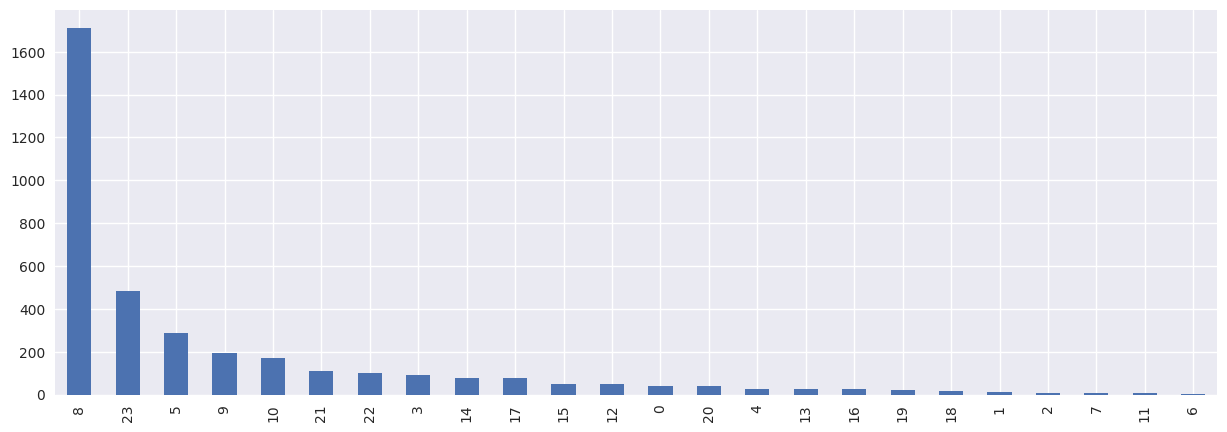

In [43]:
figure = plt.figure(figsize=(15,5))
train_data_raw['label'].value_counts().plot(kind='bar')

Oversampling underrepresented classes

In [4]:
majority_cls = train_data_raw['label'].value_counts().idxmax()
# target_count = train_data_raw['label'].value_counts().max()
target_count = 700

oversampled_data = pd.DataFrame(columns=train_data_raw.columns)

for cls in train_data_raw['label'].unique():
    if train_data_raw[train_data_raw['label']==cls].shape[0] <= 300:
        class_df = train_data_raw[train_data_raw['label'] == cls]
        num_samples = len(class_df)
        oversampling = int(target_count / num_samples)
        oversampled_data = pd.concat([oversampled_data] + [class_df] * oversampling, ignore_index=True)
    else:
        class_df = train_data_raw[train_data_raw['label'] == cls]
        oversampled_data = pd.concat([oversampled_data] + [class_df], ignore_index=True)
        
        
    # print("Class: {}, Oversampling factor: {}".format(cls, oversampling))
        
# print(majority_cls)
# print(target_count)

<Axes: >

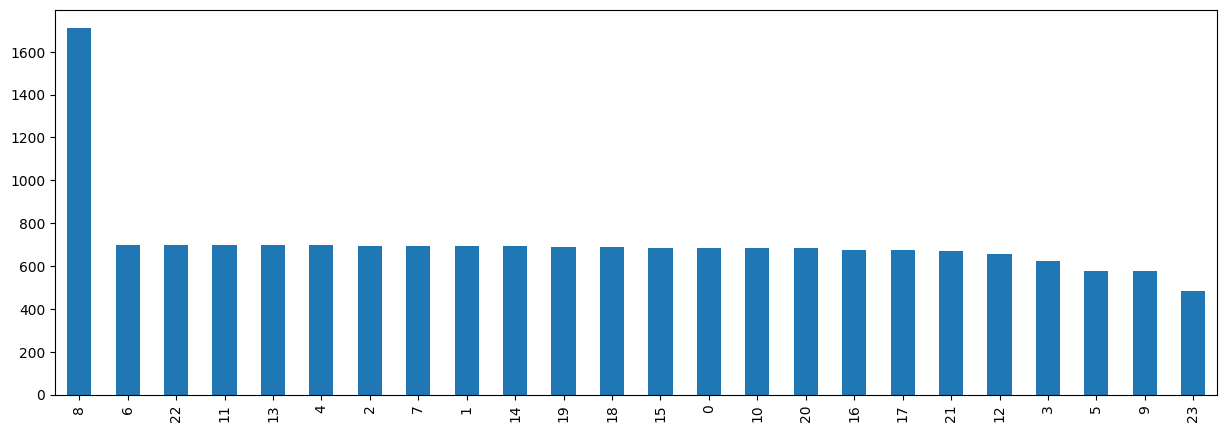

In [5]:
figure = plt.figure(figsize=(15,5))
oversampled_data['label'].value_counts().plot(kind='bar')

We choose `data_pt_per_cls` datapoints per class for all the classes so that they are all equally represented. To avoid biasing the final training dataset, we shuffle the data and *then* apply the cut.

In [6]:
train_data = pd.DataFrame(columns=train_data_raw.columns)

data_pt_per_cls = 300

for cls in oversampled_data['label'].unique():
    class_df = oversampled_data[oversampled_data['label'] == cls]
    class_df = class_df.sample(frac=1.0, random_state=42)[:data_pt_per_cls]
    train_data = pd.concat([train_data] + [class_df], ignore_index=True)

<Axes: >

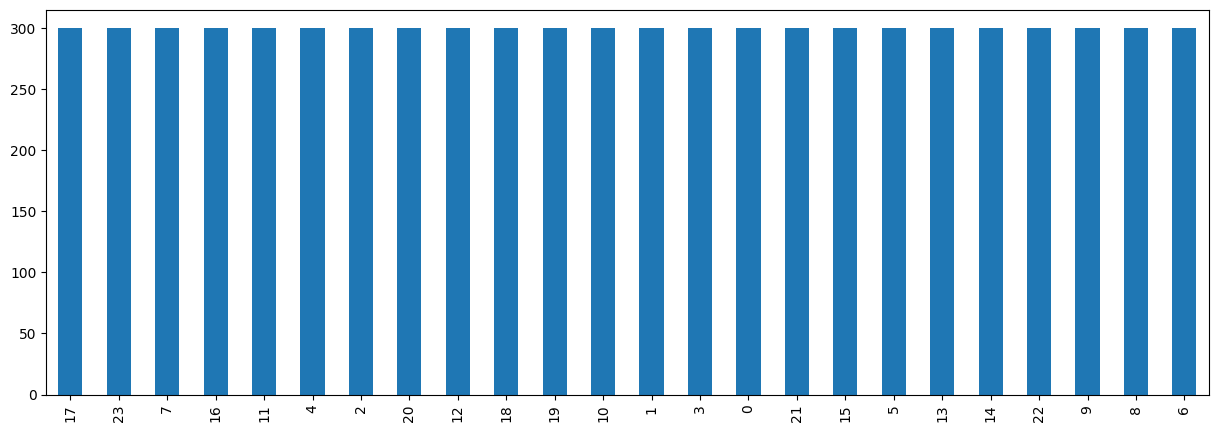

In [7]:
figure = plt.figure(figsize=(15,5))
train_data['label'].value_counts().plot(kind='bar')

Type conversion needed to feed into Keras data generator

In [8]:
train_data = train_data.convert_dtypes()
val_data_raw = val_data_raw.convert_dtypes()

train_data['label'] = train_data['label'].apply(lambda x: [x])
val_data_raw ['label'] = val_data_raw['label'].apply(lambda x: [x])

Creating the training and validation data generators

In [9]:
# training data gen
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                                    x_col = "image",
                                                    y_col = "label",
                                                    target_size=Config.img_dimensions,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    directory='/domino/datasets/UPRM_Hackathon_2023')

# validation data gen
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_data_raw, 
                                                x_col = "image",
                                                y_col = "label",
                                                target_size=Config.img_dimensions,
                                                batch_size=32,
                                                class_mode='categorical',
                                                directory='/domino/datasets/UPRM_Hackathon_2023')

Found 7193 validated image filenames belonging to 24 classes.


/home/ubuntu/.local/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 7 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 1555 validated image filenames belonging to 24 classes.


/home/ubuntu/.local/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


# Model Building & Training
We apply transfer learning to minimize training time and maximize model performance

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file= '/mnt/ItDepends/ItDepends_folder/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (128, 128, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


Adding last layers to the transferred model

In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(24, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

Defining a model checkpoint callback which saves the model weights to maximize AUC for ROC 

In [13]:
f1_obj = tf.keras.metrics.F1Score

In [37]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/mnt/ItDepends/ItDepends_folder/model.hdf5',
    # save_weights_only=True,
    # monitor=tf.keras.metrics.AUC().name,
    # monitor = 'auc',
    monitor = 'val_loss',
    mode='min',
    save_best_only=True)

We can now compile the final model structure. We track accuracy and AUC, and we use the Adadelta optimizer with an initial learning rate of 1 and a categorical cross entropy loss.

In [33]:
from keras import backend as K

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [38]:
model.compile(
    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=24, from_logits=False),
              f1_score])

And now we train!

In [40]:
history = model.fit(
    x=train_generator,  
    epochs=10,
    validation_data=val_generator,  
    verbose=2,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
225/225 - 97s - loss: 0.0683 - accuracy: 0.9766 - auc_1: 0.9992 - f1_score: 0.9765 - val_loss: 0.1216 - val_accuracy: 0.9608 - val_auc_1: 0.9991 - val_f1_score: 0.9620 - 97s/epoch - 431ms/step
Epoch 2/10
225/225 - 97s - loss: 0.0662 - accuracy: 0.9794 - auc_1: 0.9989 - f1_score: 0.9795 - val_loss: 0.1172 - val_accuracy: 0.9653 - val_auc_1: 0.9986 - val_f1_score: 0.9652 - 97s/epoch - 432ms/step
Epoch 3/10
225/225 - 98s - loss: 0.0655 - accuracy: 0.9783 - auc_1: 0.9991 - f1_score: 0.9786 - val_loss: 0.0909 - val_accuracy: 0.9717 - val_auc_1: 0.9988 - val_f1_score: 0.9718 - 98s/epoch - 434ms/step
Epoch 4/10
225/225 - 100s - loss: 0.0576 - accuracy: 0.9791 - auc_1: 0.9993 - f1_score: 0.9800 - val_loss: 0.0825 - val_accuracy: 0.9717 - val_auc_1: 0.9988 - val_f1_score: 0.9718 - 100s/epoch - 443ms/step
Epoch 5/10
225/225 - 99s - loss: 0.0607 - accuracy: 0.9815 - auc_1: 0.9990 - f1_score: 0.9819 - val_loss: 0.0718 - val_accuracy: 0.9833 - val_auc_1: 0.9985 - val_f1_score: 0.9828 - 9

Saving the model structure in `itdepends_model.hdf5` and `itdepends_weights.hdf5`.

In [41]:
model.save("model_v2_2.hdf5") 

In [138]:
# model.save_weights("itdepends_weights.hdf5")

Plotting the training and validating accuracy and loss

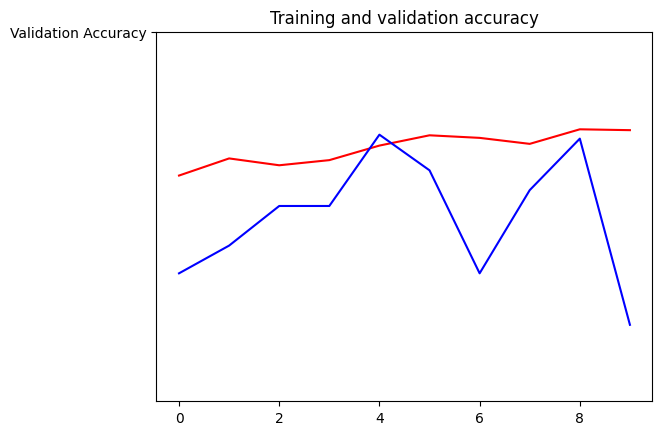

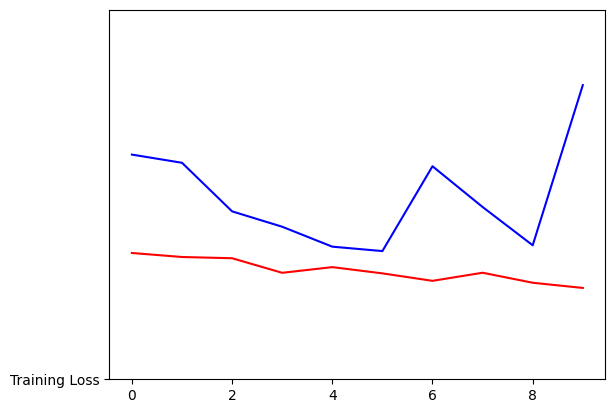

In [45]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.ylim(0.94,1)
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.ylim(0,0.2)
plt.show()

# Model Testing
Now we show the trained model data it hasn't seen before. From this we construct a confusion matrix to get a better idea of how it performs.

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score as f1_sk

In [60]:
f1_sk

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [47]:
# Same data type conversion done before, but this time for test data
test_data_raw = test_data_raw.convert_dtypes()
test_data_raw ['label'] = test_data_raw['label'].apply(lambda x: [x])

In [48]:
# test data gen
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_raw, 
                                                x_col = "image",
                                                y_col = "label",
                                                target_size=Config.img_dimensions,
                                                # batch_size=32,
                                                class_mode='categorical',
                                                directory='/domino/datasets/UPRM_Hackathon_2023',
                                                shuffle=False)

Found 1505 validated image filenames belonging to 24 classes.


In [49]:
# Pre-test of model as a sanity check
model.evaluate(test_generator)

48/48 [==============================] - 7s 152ms/step - loss: 0.2325 - accuracy: 0.9601 - auc_1: 0.9916 - f1_score: 0.9612


[0.23253129422664642,
 0.960132896900177,
 0.9915969371795654,
 0.9611958861351013]

In [50]:
test_predict = model.predict(test_generator)

48/48 [==============================] - 8s 151ms/step


In [51]:
test_predict = np.argmax(test_predict, axis=1)

In [52]:
cm = confusion_matrix(np.ravel(test_data_raw['label'].to_list()), test_predict)

In [53]:
disp = ConfusionMatrixDisplay(cm)

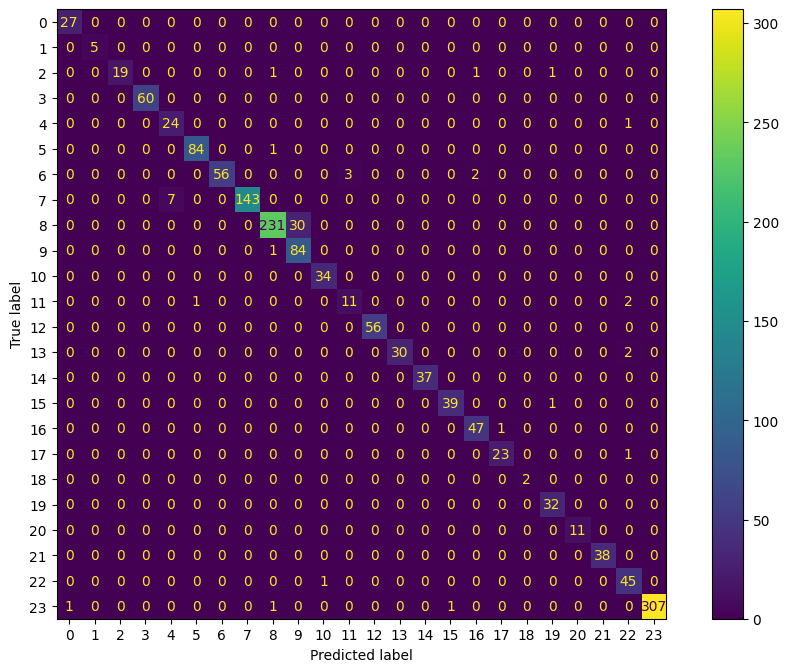

In [54]:
figure,ax = plt.subplots(dpi=99,figsize=(12,8))

disp.plot(ax=ax)
figure.savefig('cm.pdf')
plt.show()

In [55]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [61]:
# cm = confusion_matrix(np.ravel(test_data_raw['label'].to_list()), test_predict)
F1_score = f1_sk(np.ravel(test_data_raw['label'].to_list()), test_predict, average='macro')

print(f'f1_score: {F1_score}')
print(f"{bcolors.FAIL}{bcolors.BOLD}{bcolors.UNDERLINE}Recall: Criteria for winning submissions is determined by the F1 score above!")

f1_score: 0.9578009479615192
Recall: Criteria for winning submissions is determined by the F1 score above!
